In this notebook we introduce a full worked example of applying the time dependnent Gaussian process model

We are modelling the distribution of the stochastic process
$$
    \mathbf{X}(t) = \mathbf{A}(t) \mathbf{X} + \mathbf{f}(t)
$$
where $\mathbf{A}(t)$ is a piecewise-constant matrix valued function and $\mathbf{f}(t)$ is a (smooth) Gaussian process. We therefore need to let our model know the intervals on which $\mathbf{A}(t)$ is constant

In [79]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import Example1
import scipy.linalg

from timevarying_covar import time_discretisation_handler
def At(t):
    return np.array([[-1., -2.],[3., -4]])

tt = np.array([.1, .5, 1.8, 2.1]) # Observation times of data
tk = np.array([0., 1., 3.])     # Intervals on which A(t) is constant

tt *= 100
tk *= 100


# ttm = [ (tk[0]+tt[0])/2. , (tk[0]+tt[1])]
tta, ttm, ttb,_ = time_discretisation_handler(tt, tk, lambda x: None, 2)
Att = [At(t) for t in ttm]

Ati = []
for i in range(tt.size):
    # find the interval in which t[i] is in 
    interval = sum(tk < tt[i])
    Ati.append( At( 0.5*(tk[interval-1] + tk[interval] )) )

Atk = []
# assume that tk[-1] > tt[i] so it breaks before out of range
for i in range(tk.size):
    if tk[i+1] < tt[-1]:
        Atk.append( At(0.5*(tk[i]+tk[i+1])) )
    else:
        break

In [80]:
def makeT( Ati, Atk, tt, tk, dim):
    NG = sum(tk < tt[-1]) - 1
    Id = np.diag(np.ones(dim))
    
    result = np.zeros((tt.size*dim, NG*dim))
    
    for i in range(tt.size):
        result[i*dim:(i+1)*dim, :] = np.column_stack((Id for nt in range(NG)))
        
        tauSet = tk[tk < tt[i]]
        tauSet = tauSet[1:]
        
        if len(tauSet > 0):
            for nt in range(tauSet.size - 1):
                eA = scipy.linalg.expm(Atk[nt+1]*(tauSet[nt+1]-tauSet[nt]))
                for k in range(nt+1):
                    result[i*dim:(i+1)*dim, k*dim:(k+1)*dim] = np.dot(eA, result[i*dim:(i+1)*dim, k*dim:(k+1)*dim] )
            
            eAi = scipy.linalg.expm(Ati[i]*(tt[i] - tauSet[-1]))
            for k in range(len(tauSet)):
                result[i*dim:(i+1)*dim, k*dim:(k+1)*dim] = np.dot( eAi, result[i*dim:(i+1)*dim, k*dim:(k+1)*dim] )
    
    return result

T = makeT( Ati, Atk, tt, tk, 2).shape

In [81]:
## Make covariance matrix
#from core import makeCovarMat_sqExpk_specDecomp_noSens_2 as makeCov

N = len(Ati) + len(Atk)
A = Ati + Atk
dim = 2
Cov = np.zeros((N*dim, N*dim))

###
timeScale = tt[-1] - tt[0]

tt_ = np.concatenate((tt, [tk[1]])) / timeScale


lScales = np.array([1., 1.]) / timeScale
cScales = np.array([0., 1.])*timeScale**2


for i in range(N):
    a = timeScale*A[i]
    Aeig, UA = np.linalg.eig(a)
    UAinv = np.linalg.inv(a)
    for j in range(i+1):
        b = timeScale*A[j].T
        Beig, UB = np.linalg.eig(b)
        UBinv = np.linalg.inv(b)
        
#        kval = makeCov(np.array([tt_[i]]), np.array([tt_[j]]), (Aeig, UA, UAinv), (Beig, UB, UBinv), lScales, cScales, 2, 0., 0.)
#        Cov[i*dim:(i+1)*dim, j*dim:(j+1)*dim] = kval
#        Cov[j*dim:(j+1)*dim, i*dim:(i+1)*dim] = kval.T



[[ nan  nan]
 [ nan  nan]]
[[ nan  nan]
 [ nan  nan]]


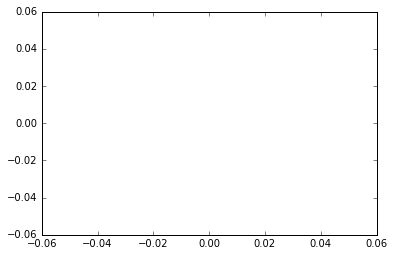

In [82]:
from timevarying_covar_src import getCov

C = getCov(tt, tk, At, np.array([0., 1.]), np.array([100., 303.]), 2, 0., 0., True)


var = np.diag(C).reshape(tt.size, 2)

from core import makeCovarMat_sqExpk_specDecomp_noSens_2 as makeCov

i = 2
j = 3

Aeig, UA = np.linalg.eig( At(tt[i] ))
UAinv = np.linalg.inv(UA)
Beig, UB = np.linalg.eig( At(tt[j]).T)
UBinv = np.linalg.inv(UB)

lScales = np.array([1., 3.])
cScales = np.array([0., 10.])

kval = makeCov(np.array([tt[i]]), np.array([tt[j]]), (Aeig, UA, UAinv), (Beig, UB, UBinv), lScales, cScales, 2, 0., 0.)

print C[i*2:(i+1)*2, j*2:(j+1)*2]
print kval

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tt, var)

Trying to get to grips with overflow issues in the covariance

In [30]:
def func(S, T, d1, d2, l, c, s0, t0):
    a1 = -(d1 + d2)*(S + d1*l**2)
    b1 = (d1 + d2)*np.sqrt(2.)*l
    lower1 = (S + d1*l**2 - t0)/(np.sqrt(2.)*l)
    upper1 = (S + d1*l**2 - T)/(np.sqrt(2.)*l)
    print lower1, upper1, a1, b1
    
func(10, 20, -3, -2., 10., 1., 0. , 0.)
func(10./20, 20./20., -3.*20, -2*20., 1./20., 1*20**2, 0., 0. )

-20.5060966544 -21.9203102168 -1450.0 -70.7106781187
4.94974746831 -9.19238815543 35.0 -7.07106781187


In [12]:
from scipy.special import erf
def func(lower, upper, a, b):
    expr1 = np.exp(0.25*b**2)*erf(0.5*b - upper) + np.exp(b*upper)*erf(upper)
    expr2 = np.exp(0.25*b**2)*erf(0.5*b - lower) + np.exp(b*lower)*erf(lower)
    print expr1, expr2
    return np.exp(a)*(expr1 - expr2)/b

print np.exp(-3*-10)
print np.exp(-3*20)

1.06864745815e+13
8.7565107627e-27


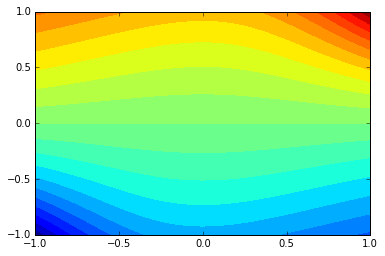

In [20]:
def f(u, c):
    return np.exp(0.25*c**2)*erf(0.5*c-u) + np.exp(c*u)*erf(u)

uu = np.linspace(-1., 1., 100)
cc = np.linspace(-1., 1., 100)

U, C = np.meshgrid(uu, cc)
Z = f(U.ravel(), C.ravel()).reshape(U.shape)

plt.contourf(U, C, Z, 30)

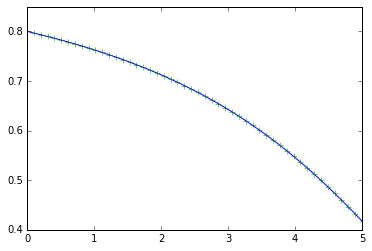

In [30]:
from scipy.integrate import odeint

def dXdt(X, t):
    return -X*(1-X)**2 


def dZdt(Z, s, a, c):
    return a*c*dXdt(Z/0.1, c*s)
    
tt = np.linspace(0., 5.)
ss = np.linspace(0., 1.)
x0 = 0.8
z0 = 0.8*0.1

x = odeint(dXdt, x0, tt)
z = odeint(dZdt, z0, ss, args=(0.1, 5., ))

    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tt, x)
ax.plot(tt, z/0.1, '+')

    

[ 0.    0.05  0.08]


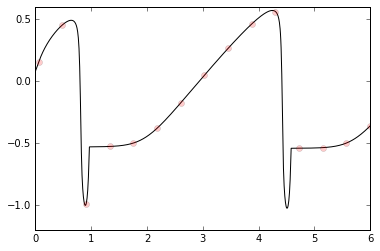

In [77]:
import Example1

initCond = [0., 0.5, 0.8]
tt = np.linspace(0., 120, 1000)


odeModel = Example1.nonlinearFrictionODE()

sol = odeModel.solve(initCond, tt)

fig = plt.figure()
ax = fig.add_subplot(111)
#ax.plot(tt, sol)

Yscale = 0.1
Tscale = 20.

def dYdt(Y,t):
    return Yscale*Tscale*odeModel.dYdt(Y/Yscale, t)

y0 = np.array(initCond)*Yscale
print y0
ss = tt/Tscale
ysol = odeint(dYdt, y0, ss)

redInd = np.linspace(10, tt.size-1, 15, dtype=np.intp)
ax.plot(ss, ysol[:,2], 'k-')
ax.plot(ss[redInd], ysol[redInd,2], 'ro', alpha=0.2)

plt.show()

(1000, 2)


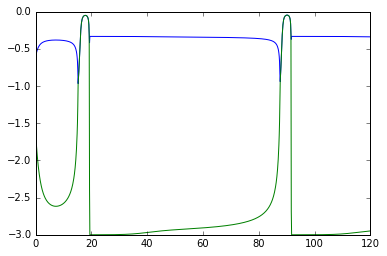

In [70]:
evals = np.array([np.linalg.eig(odeModel.dXdt_Jac(x))[0] for x in sol[:,:2]])
print evals.shape
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tt, evals)